# LDA model on oncology

provider_type: hematology, medical
- filter out least and most common hcpcs_codes (compared to model 1, which does no filtering)
- only consider in-facility claims
- number of topics = 6
- bene_unique_cnt as value

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

from gensim import matutils, models, corpora

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = """SELECT npi, nppes_provider_last_org_name, nppes_provider_state, nppes_provider_first_name,
provider_type, hcpcs_code, hcpcs_description, bene_unique_cnt
FROM payments 
WHERE (provider_type='Medical Oncology' OR provider_type='Hematology/Oncology')
AND place_of_service='O'
AND hcpcs_drug_indicator='Y'"""
payments = pd.read_sql_query(q, con=con)

In [4]:
payments.shape

(56147, 8)

In [5]:
payments['provider_type'].unique()

array(['Medical Oncology', 'Hematology/Oncology'], dtype=object)

In [6]:
## how many of each provider type?
payments.drop_duplicates('npi').groupby('provider_type')['npi'].count()

provider_type
Hematology/Oncology    3603
Medical Oncology       1056
Name: npi, dtype: int64

## construct raw data frame

In [7]:
by_npi = (payments[['npi','hcpcs_code','bene_unique_cnt']].
                pivot(index='npi', values = 'bene_unique_cnt', columns='hcpcs_code').
                fillna(value=0))
by_npi.shape

(4659, 175)

## preprocess data frame (drop top 3 codes, codes with only 1 claim, docs with < 5 claims)

### filter out extreme hcpcs_code columns (top 15 claimed codes, codes with fewer than 5 claims)

In [8]:
## What are the counts for the top claimed codes?
counts_per_code = (payments['hcpcs_code'].value_counts().
                   reset_index(name='count').
                   rename(columns={'index': 'hcpcs_code'}))

pd.set_option('max_colwidth', 80)
counts_per_code = (counts_per_code.merge(payments[['hcpcs_code', 'hcpcs_description']],
                                         on='hcpcs_code', sort=False)
                   .drop_duplicates())

top_codes_to_drop = list(counts_per_code['hcpcs_code'][:3])
counts_per_code.head(15)

,hcpcs_code,count,hcpcs_description
0,J1100,4044,"Injection, dexamethasone sodium phosphate, 1mg"
4044,J1200,3494,"Injection, diphenhydramine hcl, up to 50 mg"
7538,J2469,3056,"Injection, palonosetron hcl, 25 mcg"
10594,J2505,2325,"Injection, pegfilgrastim, 6 mg"
12919,J3489,2146,"Injection, zoledronic acid, 1 mg"
15065,J9045,2116,"Injection, carboplatin, 50 mg"
17181,J7030,2097,"Infusion, normal saline solution , 1000 cc"
19278,J3420,1994,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
21272,J0897,1743,"Injection, denosumab, 1 mg"
23015,J2405,1656,"Injection, ondansetron hydrochloride, per 1 mg"


In [9]:
## How many codes have been claimed only once?
bottom_codes_to_drop = list(counts_per_code.query('count == 1')['hcpcs_code'])

In [10]:
len(bottom_codes_to_drop)

22

In [11]:
## so total columns dropped is:
print('number of cols to drop: {0}'.format(len(bottom_codes_to_drop) + len(top_codes_to_drop)))

number of cols to drop: 25


In [12]:
by_npi.drop(labels=(top_codes_to_drop + bottom_codes_to_drop), axis=1, inplace=True)
by_npi.shape

(4659, 150)

## drop doctors with less than 5 claims

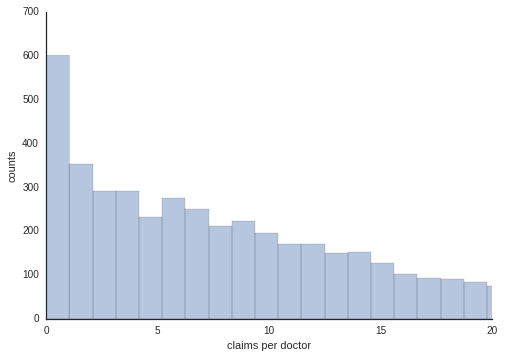

In [14]:
## How many different drug codes have been claimed per doctor?  Plot distribution

#number_of_codes_per_doctor = (by_npi > 0.0).sum(axis = 1)
g = sns.distplot((by_npi > 0.0).sum(axis = 1), kde=False, bins=50)
g.set(xlim=(0,20), xlabel='claims per doctor', ylabel='counts')
sns.despine()

In [15]:
# number of docs to drop (docs who have < 5 claims, based on the already column-filtered dataframe)
sum((by_npi > 0.0).sum(axis = 1) < 5)

1537

In [17]:
by_npi = by_npi[(by_npi > 0.0).sum(axis = 1) > 4]

In [18]:
by_npi.shape

(3122, 150)

In [19]:
## write to file
by_npi.to_csv("11f_by_npi_reduced_medical_hematology_oncolgists.csv", index=True)

## LDA on filtered data frame using 6 topics

In [20]:
corpus = matutils.Dense2Corpus(by_npi.as_matrix(), documents_columns=False)

In [21]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [22]:
time0 = time.time()
ldamodel = models.ldamodel.LdaModel(corpus_tfidf, num_topics=6, passes=20)
print('calculated in {0}s'.format(time.time()-time0))

calculated in 77.64521956443787s


In [23]:
## Save model
ldamodel.save("11f_lda_6topics_colsDropped_docsDropped_hema_medi_oncology.model", pickle_protocol=3)

## Interpret the 6 topics in the model

In [182]:
## top 15 words in each topic
topics_matrix = ldamodel.show_topics(formatted=False, num_words=20)

In [25]:
## for each topic, store indices of top 20 hcpcs_codes in a list
topic_idx_dict = {}

for i in topics_matrix:
    topic_idx_dict[i[0]] = [int(word[0]) for word in i[1]]

In [26]:
## for each topic's list of indexes, get the list of hcpcs_codes
topic_dict = {}

for k, v in topic_idx_dict.items():
    topic_dict[k] = [by_npi.columns.values[i] for i in v]

In [27]:
## Topic 0
t = 0
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
5,J1626,"Injection, granisetron hydrochloride, 100 mcg"
11,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
20,J0885,"Injection, epoetin alfa, (for non-esrd use), 1000 units"
25,J1756,"Injection, iron sucrose, 1 mg"
61,J2405,"Injection, ondansetron hydrochloride, per 1 mg"
72,Q9967,"Low osmolar contrast material, 300-399 mg/ml iodine concentration, per ml"
77,J0881,"Injection, darbepoetin alfa, 1 microgram (non-esrd use)"
100,J2916,"Injection, sodium ferric gluconate complex in sucrose injection, 12.5 mg"
195,J1446,"Injection, tbo-filgrastim, 5 micrograms"
218,Q2035,"Influenza virus vaccine, split virus, when administered to individuals 3 yea..."


In [28]:
## Topic 1
t = 1
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
3,J1442,"Injection, filgrastim (g-csf), 1 microgram"
5,J1626,"Injection, granisetron hydrochloride, 100 mcg"
7,J1750,"Injection, iron dextran, 50 mg"
11,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
12,J7030,"Infusion, normal saline solution , 1000 cc"
13,J7040,"Infusion, normal saline solution, sterile (500 ml=1 unit)"
19,Q2037,"Influenza virus vaccine, split virus, when administered to individuals 3 yea..."
20,J0885,"Injection, epoetin alfa, (for non-esrd use), 1000 units"
21,J0897,"Injection, denosumab, 1 mg"
25,J1756,"Injection, iron sucrose, 1 mg"


In [29]:
## Topic 2
t = 2
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
4,J1453,"Injection, fosaprepitant, 1 mg"
5,J1626,"Injection, granisetron hydrochloride, 100 mcg"
7,J1750,"Injection, iron dextran, 50 mg"
9,J2505,"Injection, pegfilgrastim, 6 mg"
11,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
12,J7030,"Infusion, normal saline solution , 1000 cc"
18,J9265,"Injection, paclitaxel, 30 mg"
19,Q2037,"Influenza virus vaccine, split virus, when administered to individuals 3 yea..."
21,J0897,"Injection, denosumab, 1 mg"
28,J2780,"Injection, ranitidine hydrochloride, 25 mg"


In [30]:
## Topic 3
t = 3
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
6,J1642,"Injection, heparin sodium, (heparin lock flush), per 10 units"
11,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
12,J7030,"Infusion, normal saline solution , 1000 cc"
13,J7040,"Infusion, normal saline solution, sterile (500 ml=1 unit)"
20,J0885,"Injection, epoetin alfa, (for non-esrd use), 1000 units"
21,J0897,"Injection, denosumab, 1 mg"
25,J1756,"Injection, iron sucrose, 1 mg"
61,J2405,"Injection, ondansetron hydrochloride, per 1 mg"
77,J0881,"Injection, darbepoetin alfa, 1 microgram (non-esrd use)"
104,J7050,"Infusion, normal saline solution , 250 cc"


In [31]:
## Topic 4
t = 4
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
3,J1442,"Injection, filgrastim (g-csf), 1 microgram"
7,J1750,"Injection, iron dextran, 50 mg"
9,J2505,"Injection, pegfilgrastim, 6 mg"
11,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
12,J7030,"Infusion, normal saline solution , 1000 cc"
15,J9045,"Injection, carboplatin, 50 mg"
17,J9190,"Injection, fluorouracil, 500 mg"
19,Q2037,"Influenza virus vaccine, split virus, when administered to individuals 3 yea..."
20,J0885,"Injection, epoetin alfa, (for non-esrd use), 1000 units"
21,J0897,"Injection, denosumab, 1 mg"


In [32]:
## Topic 5
t = 5
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
4,J1453,"Injection, fosaprepitant, 1 mg"
5,J1626,"Injection, granisetron hydrochloride, 100 mcg"
12,J7030,"Infusion, normal saline solution , 1000 cc"
13,J7040,"Infusion, normal saline solution, sterile (500 ml=1 unit)"
19,Q2037,"Influenza virus vaccine, split virus, when administered to individuals 3 yea..."
61,J2405,"Injection, ondansetron hydrochloride, per 1 mg"
77,J0881,"Injection, darbepoetin alfa, 1 microgram (non-esrd use)"
104,J7050,"Infusion, normal saline solution , 250 cc"
153,J7042,5% dextrose/normal saline (500 ml = 1 unit)
227,J1644,"Injection, heparin sodium, per 1000 units"


## Plot distribution of providers per topic

In [33]:
## per document (provider), assign topic based on highest-probability topic out of the 10
topic_per_doc = []
for i in corpus_tfidf:
    topic_per_doc.append(np.argmax(np.array(ldamodel.get_document_topics(i))[:,1]))

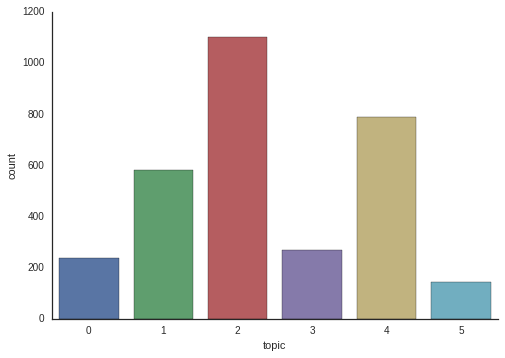

In [34]:
## distribution of providers among topics
ax = sns.countplot(x='topic',data=pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}))
sns.despine()

## Color code distribution over topics by provider_type

In [35]:
by_npi.index = by_npi.index.astype(str)

In [36]:
color_codes = (pd.DataFrame({'npi':by_npi.index}).
               merge(payments.drop_duplicates('npi')[['npi', 'provider_type']]))

In [37]:
## color code for plotting
len(color_codes)

3122

In [38]:
color_codes.head()

,npi,provider_type
0,1003031212,Hematology/Oncology
1,1003079997,Hematology/Oncology
2,1003099813,Hematology/Oncology
3,1003801689,Hematology/Oncology
4,1003805375,Hematology/Oncology


In [39]:
topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}),
                              color_codes], axis=1, ignore_index=True).
                    rename(columns={0:'topic',1:'npi',2:'provider_type'}))

topic_per_doc_df.head()
#topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc), fraud_label], axis=1, ignore_index=True).
#                        rename(columns={0:'topic',1:'fraud'}))

,topic,npi,provider_type
0,4,1003031212,Hematology/Oncology
1,3,1003079997,Hematology/Oncology
2,1,1003099813,Hematology/Oncology
3,1,1003801689,Hematology/Oncology
4,2,1003805375,Hematology/Oncology


In [40]:
mydf = (topic_per_doc_df.
        groupby(['topic','provider_type']).
        count().
        rename(columns={'npi':'counts'}).
        reset_index())

In [41]:
mydf.head(10)

,topic,provider_type,counts
0,0,Hematology/Oncology,185
1,0,Medical Oncology,54
2,1,Hematology/Oncology,473
3,1,Medical Oncology,107
4,2,Hematology/Oncology,815
5,2,Medical Oncology,286
6,3,Hematology/Oncology,226
7,3,Medical Oncology,44
8,4,Hematology/Oncology,611
9,4,Medical Oncology,179


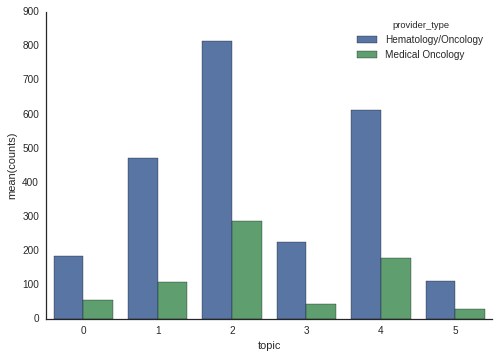

In [42]:
ax = sns.barplot(x='topic', y='counts', hue='provider_type', data=mydf)
sns.despine()

In [43]:
## plot fractions per provider_type rather than absolute counts across topics

## rescale each of the counts by overall total per fraud group
#mydf.groupby(['provider_type']).transform(lambda x: x.sum()['counts'])
types = list(payments['provider_type'].unique())

for t in types:
    mydf.loc[mydf.provider_type == t, 'counts']  = (mydf.loc[mydf.provider_type == t, 'counts'] / 
                                          float(sum(mydf.loc[mydf.provider_type == t, 'counts'])))

mydf.head()

,topic,provider_type,counts
0,0,Hematology/Oncology,0.076383
1,0,Medical Oncology,0.077143
2,1,Hematology/Oncology,0.195293
3,1,Medical Oncology,0.152857
4,2,Hematology/Oncology,0.336499


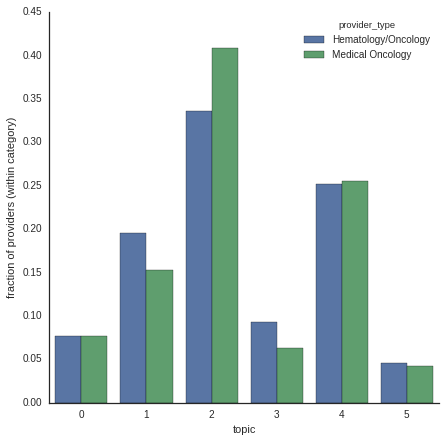

In [105]:
ax = sns.barplot(x='topic', y='counts', hue='provider_type', data=mydf)
ax.set(ylabel = "fraction of providers (within category)")
sns.despine()

## Plot doctors in topic space

In [45]:
from sklearn.manifold import TSNE
#from sklearn import preprocessing

In [46]:
topics_per_doc = []

## Get features per doc (probability scores over topics)
for doc in corpus_tfidf:
    topics_per_doc.append(np.array(ldamodel.get_document_topics(doc))[:,1])

by_npi_topics = pd.DataFrame(topics_per_doc)
by_npi_topics.shape

(3122, 6)

In [47]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi_topics.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3122
[t-SNE] Computed conditional probabilities for sample 2000 / 3122
[t-SNE] Computed conditional probabilities for sample 3000 / 3122
[t-SNE] Computed conditional probabilities for sample 3122 / 3122
[t-SNE] Mean sigma: 0.005392
[t-SNE] Iteration 25: error = 1.7571929, gradient norm = 0.0078417
[t-SNE] Iteration 50: error = 1.5677687, gradient norm = 0.0058445
[t-SNE] Iteration 75: error = 0.9790765, gradient norm = 0.0022537
[t-SNE] Iteration 100: error = 0.8856335, gradient norm = 0.0018526
[t-SNE] Error after 100 iterations with early exaggeration: 0.885634
[t-SNE] Iteration 125: error = 0.7498441, gradient norm = 0.0013426
[t-SNE] Iteration 150: error = 0.7119430, gradient norm = 0.0012146
[t-SNE] Iteration 175: error = 0.7028211, gradient norm = 0.0011860
[t-SNE] Iteration 200: error = 0.7004034, gradient norm = 0.0011781
[t-SNE] Iterat

In [48]:
X_embedded_df = pd.DataFrame(X_embedded)
X_embedded_df = (pd.concat([X_embedded_df, topic_per_doc_df['provider_type']], 
                           axis=1, ignore_index=True).rename(columns={0:'x', 1:'y', 2:'provider_type'}))

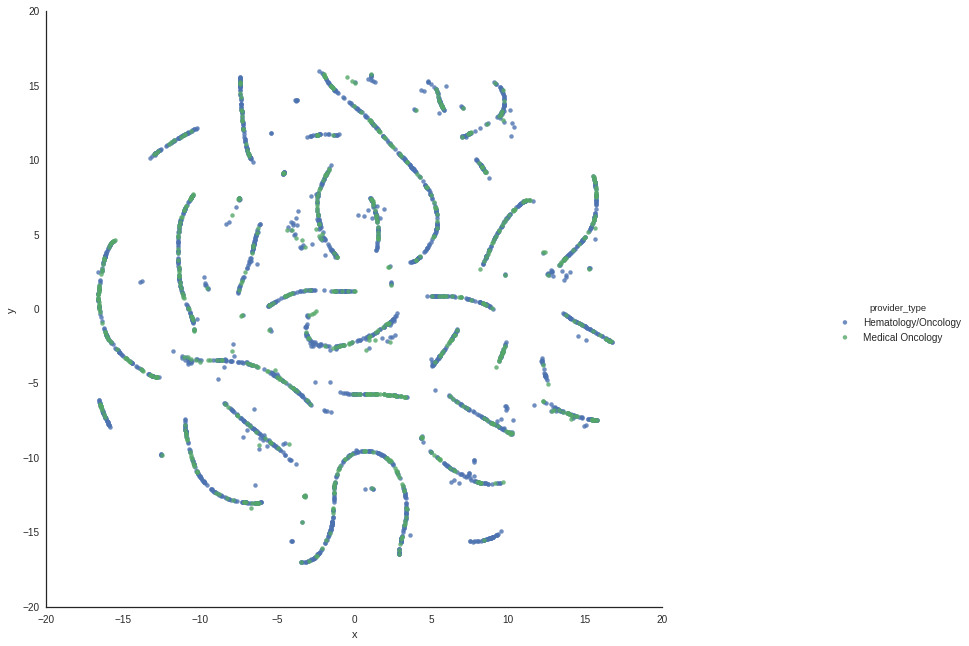

In [49]:
#plt.rcParams['figure.figsize'] = (20.0, 20.0)
#plt.figure(figsize=(8, 6))
plt.rcParams['figure.figsize']=(10,20)
fig = plt.figure(figsize=(10,10))
sns.lmplot(x='x', y='y', data=X_embedded_df, hue='provider_type', fit_reg=False)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(15)

## tsne on original space

In [50]:
X_embedded0 = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3122
[t-SNE] Computed conditional probabilities for sample 2000 / 3122
[t-SNE] Computed conditional probabilities for sample 3000 / 3122
[t-SNE] Computed conditional probabilities for sample 3122 / 3122
[t-SNE] Mean sigma: 19.934726
[t-SNE] Iteration 25: error = 1.6964095, gradient norm = 0.0064720
[t-SNE] Iteration 50: error = 1.6115091, gradient norm = 0.0042120
[t-SNE] Iteration 75: error = 1.3764027, gradient norm = 0.0014628
[t-SNE] Iteration 100: error = 1.3340213, gradient norm = 0.0012166
[t-SNE] Error after 100 iterations with early exaggeration: 1.334021
[t-SNE] Iteration 125: error = 1.2682078, gradient norm = 0.0008613
[t-SNE] Iteration 125: gradient norm 0.000861. Finished.
[t-SNE] Error after 125 iterations: 1.268208


In [51]:
X_embedded_df0 = pd.DataFrame(X_embedded0)
X_embedded_df0 = (pd.concat([X_embedded_df0, topic_per_doc_df['provider_type']], axis=1, ignore_index=True)).rename(columns={0:'x', 1:'y', 2:'provider_type'})

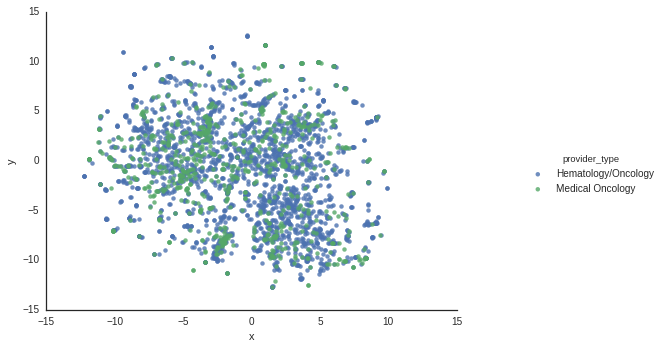

In [56]:
#plt.rcParams['figure.figsize'] = (20.0, 20.0)
#plt.figure(figsize=(8, 6))
#plt.rcParams['figure.figsize']=(10,10)
fig = plt.figure(figsize=(10,10))
sns.lmplot(x='x', y='y', data=X_embedded_df0, hue='provider_type', fit_reg=False)
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(10)

## quantify sharpness of probability distribution over topics per doctor

In [57]:
by_npi_topics.head()

,0,1,2,3,4,5
0,0.036175,0.036247,0.036324,0.036230,0.818888,0.036137
1,0.068807,0.069031,0.069402,0.654510,0.069423,0.068826
2,0.055753,0.720105,0.056203,0.055874,0.056239,0.055827
3,0.056647,0.715555,0.057700,0.056722,0.056671,0.056704
4,0.051523,0.051766,0.742060,0.051519,0.051594,0.051538


In [106]:
entropy_per_npi = by_npi_topics.apply(np.log, axis=1).mul(by_npi_topics).sum(axis=1).multiply(-1)

In [107]:
len(entropy_per_npi)

3122

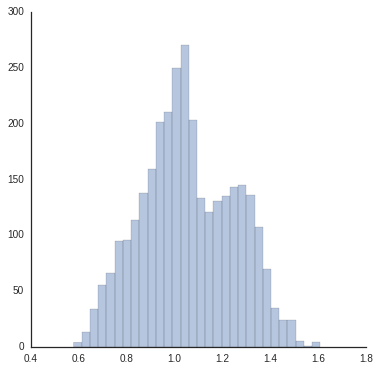

In [108]:
plt.rcParams['figure.figsize']=(6,6)
g = sns.distplot(entropy_per_npi, kde=False, bins=30)
#g.set(xlim=(0,500), ylim=(0, 60), xlabel='claims per drug B code', ylabel='counts')
sns.despine()   

In [109]:
##  maximum entropy over 6 topics = -6 * (1/6)log(1/6)
-1*np.log(1/6)

1.791759469228055

There used to be about 120 providers with completely uniform probability distributions (max entropy) when I kept any doctors with more than 1 claim.  That spike is erased by increasing the threshold number of claims when choosing which doctors to drop.

How is entropy distributed between provider_types?

In [110]:
entropy_df = pd.concat([color_codes, pd.DataFrame(entropy_per_npi)], axis=1).rename(columns={0:'entropy'})

In [111]:
entropy_df.head()

,npi,provider_type,entropy
0,1003031212,Hematology/Oncology,0.764564
1,1003079997,Hematology/Oncology,1.200652
2,1003099813,Hematology/Oncology,1.043327
3,1003801689,Hematology/Oncology,1.054891
4,1003805375,Hematology/Oncology,0.986030


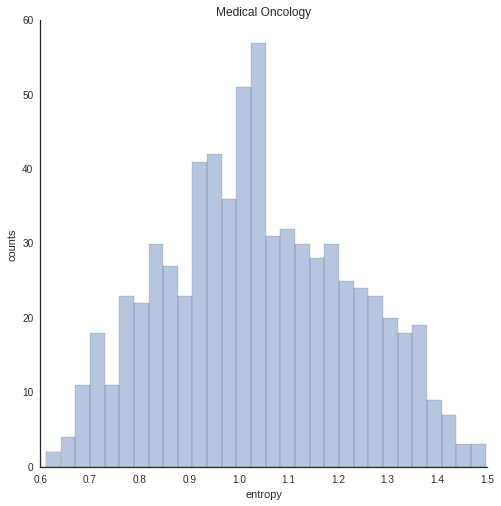

In [112]:
plt.rcParams['figure.figsize']=(8,8)
g = sns.distplot(entropy_df.query("provider_type=='Medical Oncology'")['entropy'], kde=False, bins=30)
g.set(xlabel='entropy', ylabel='counts', title='Medical Oncology')
sns.despine()

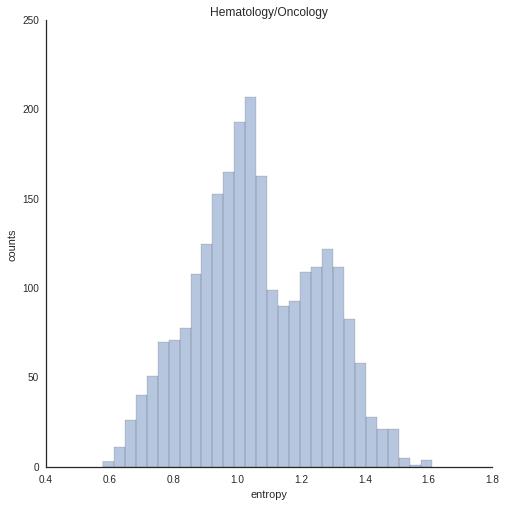

In [113]:
plt.rcParams['figure.figsize']=(8,8)
g = sns.distplot(entropy_df.query("provider_type=='Hematology/Oncology'")['entropy'], kde=False, bins=30)
g.set(xlabel='entropy', ylabel='counts', title='Hematology/Oncology')
sns.despine()

In [117]:
## Look at the lower entropy providers
low_entropy_providers = (entropy_df.query('entropy < 0.8').
                         sort_values('entropy', ascending=True).
                         merge(payments.drop_duplicates('npi')[['npi','nppes_provider_last_org_name',
                                        'nppes_provider_first_name',
                                        'nppes_provider_state']], on='npi').
                            merge(topic_per_doc_df[['npi','topic']], on='npi'))
low_entropy_providers.head(10)

,npi,provider_type,entropy,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic
0,1245221993,Hematology/Oncology,0.577749,HART,LOWELL,FL,4
1,1336130046,Hematology/Oncology,0.603775,CHU,LUIS,FL,4
2,1821058496,Hematology/Oncology,0.607288,MALHOTRA,VIKAS,FL,4
3,1659375145,Medical Oncology,0.610953,TABER,DAVID,IN,2
4,1780654889,Hematology/Oncology,0.621305,LIPMAN,ANDREW,FL,4
5,1033192570,Hematology/Oncology,0.625148,RUBIN,MARK,FL,4
6,1922001064,Hematology/Oncology,0.627440,ALBERICO,THOMAS,VA,2
7,1750372686,Hematology/Oncology,0.628255,SACHDEVA,KUSH,NJ,4
8,1568468544,Hematology/Oncology,0.635748,ROTHSCHILD,NEAL,FL,4
9,1467445999,Medical Oncology,0.636832,DANSO,MICHAEL,VA,2


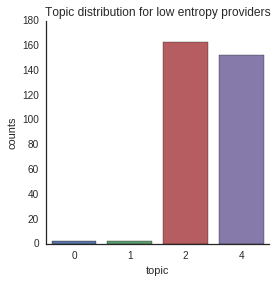

In [118]:
plt.rcParams['figure.figsize']=(4,4)
g = sns.countplot(x = 'topic', data=low_entropy_providers)
g.set(xlabel='topic', ylabel='counts', title='Topic distribution for low entropy providers')
sns.despine()

In [119]:
low_entropy_providers.query('topic == 0')

,npi,provider_type,entropy,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic
75,1871535823,Medical Oncology,0.700190,BERRYMAN,ROBERT,TX,0
128,1063406163,Hematology/Oncology,0.725395,KOSTER,DAVID,CA,0


- Robert Berryman - myeloma, lymphoma, leukemia specialist (http://www.vitals.com/doctors/Dr_Robert_Berryman/profile, http://tannersjourney.blogspot.com/2011/05/dr-robert-berryman.html).
- David Koster - leukemia (http://www.vitals.com/doctors/Dr_David_Koster/profile -- although he is identified as orthopaedic surgeon under his profile photo on vitals.com)

In [120]:
low_entropy_providers.query('topic == 1')

,npi,provider_type,entropy,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic
276,1518165943,Hematology/Oncology,0.786738,RAHMAN,FAHD,NJ,1
280,1982670147,Hematology/Oncology,0.787005,DOSTER,JOHN,SC,1


- Fahd Rahman - lymphoma, leukemia (http://www.vitals.com/doctors/Dr_Fahd_Rahman/profile)
- John Doster - specialties not listed on http://www.vitals.com/doctors/Dr_John_Doster/profile

In [121]:
low_entropy_providers.query('topic == 4').head(10)

,npi,provider_type,entropy,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,topic
0,1245221993,Hematology/Oncology,0.577749,HART,LOWELL,FL,4
1,1336130046,Hematology/Oncology,0.603775,CHU,LUIS,FL,4
2,1821058496,Hematology/Oncology,0.607288,MALHOTRA,VIKAS,FL,4
4,1780654889,Hematology/Oncology,0.621305,LIPMAN,ANDREW,FL,4
5,1033192570,Hematology/Oncology,0.625148,RUBIN,MARK,FL,4
7,1750372686,Hematology/Oncology,0.628255,SACHDEVA,KUSH,NJ,4
8,1568468544,Hematology/Oncology,0.635748,ROTHSCHILD,NEAL,FL,4
10,1164413076,Hematology/Oncology,0.639941,SUDHINDRA,RAMA,NJ,4
13,1003807645,Medical Oncology,0.644488,LUNIN,SCOTT,FL,4
14,1346214384,Hematology/Oncology,0.645108,KUKUNOOR,RAJESH,AZ,4


In [122]:
entropy_df_claimcnt = (pd.concat([entropy_df, pd.DataFrame((by_npi > 0).sum(axis = 1)).reset_index()], 
                                 axis=1).rename(columns={0:'num_claims'}))

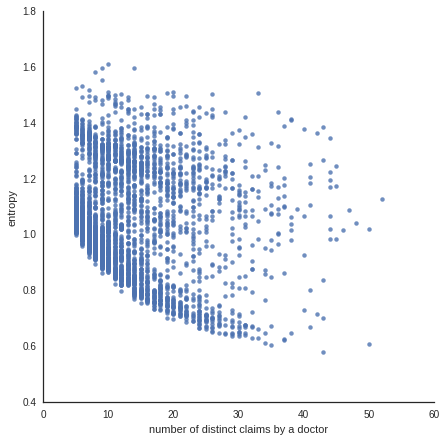

In [123]:
plt.rcParams['figure.figsize']=(7,7)
ax = sns.regplot(x="num_claims", y="entropy", data=entropy_df_claimcnt, fit_reg=False)
ax.set(xlabel='number of distinct claims by a doctor', ylabel='entropy')
sns.despine()

## Read in map between indications and hcpcs_codes

In [124]:
icd9_hcpcs_map = pd.read_csv("15_rxcui_hcpcs_map_6categories.csv")
icd9_hcpcs_map.head()

,rxcui_in,drug_name,keywords_indication_desc,hcpcs_code,hcpcs_description
0,12574,gemcitabine,genitourinary,J9201,"injection, gemcitabine hydrochloride, 200 mg"
1,993449,denosumab,genitourinary,J0897,"injection, denosumab, 1 mg"
2,38782,triptorelin,genitourinary,J3315,"injection, triptorelin pamoate, 3.75 mg"
3,50610,goserelin,genitourinary,J9202,"goserelin acetate implant, per 3.6 mg"
4,996051,cabazitaxel,genitourinary,J9043,"injection, cabazitaxel, 1 mg"


In [183]:
topics_hcpcs = {}

## convert topic word indices to hcpcs_codes => value is a list of tuples of (hcpcs_code, probability)
for i in topics_matrix:
    topics_hcpcs[i[0]] = [(by_npi.columns.values[int(word[0])], word[1]) for word in i[1]]

In [173]:
def converter(t):
    topic_t_df = (pd.DataFrame(topics_hcpcs[t]).
                  rename(columns={0:'hcpcs_code',1:'probability'}).
                  merge(icd9_hcpcs_map[['hcpcs_code','keywords_indication_desc']], on='hcpcs_code'))
    print(len(topic_t_df))              
    return topic_t_df

In [174]:
def get_likely_indication(t):
    df = converter(t)
    if len(df) > 0:
        summed_probs = df.groupby('keywords_indication_desc')['probability'].sum().reset_index()
        print(summed_probs)
        idx = summed_probs['probability'].idxmax
        return summed_probs.loc[idx, 'keywords_indication_desc']
    else:
        print('no matches to medi_indications')

In [184]:
for i in range(6):
    print('topic ', i, get_likely_indication(i),'\n')

0
no matches to medi_indications
topic  0 None 

5
  keywords_indication_desc  probability
0              breast_skin     0.016607
1                eye_brain     0.016607
2            genitourinary     0.034813
3              lymph_blood     0.016607
topic  1 genitourinary 

21
  keywords_indication_desc  probability
0              breast_skin     0.109851
1                digestive     0.037341
2                eye_brain     0.072510
3            genitourinary     0.115079
4              lymph_blood     0.068569
5              respiratory     0.067166
topic  2 genitourinary 

5
  keywords_indication_desc  probability
0              breast_skin     0.015922
1                eye_brain     0.015922
2            genitourinary     0.040096
3              lymph_blood     0.015922
topic  3 genitourinary 

17
  keywords_indication_desc  probability
0              breast_skin     0.090409
1                digestive     0.046650
2                eye_brain     0.043759
3            genitourinary